In [2]:
# basin-sizes-to-control-kernel-sizes.ipynb
#
# Bryan Daniels
# 2024/1/4
#
# Can we use basin sizes to better predict control kernel sizes?
#
# An outgrowth from cell-collective-basin-entropy.ipynb

In [115]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from toolbox.simplePickle import load

In [25]:
# useful code for dealing with cell collective networks from from code/cellCollective.py
def directory_name(n_name):
    """
    Returns the name of the Cell Collective directory given
    the "nice" name with spaces
    """
    return n_name.replace(' ','_').replace('.','')
    
def nice_name(dir_name):
    """
    Returns the "nice" name of the Cell Collective network
    given the directory name
    """
    nice = dir_name.replace('_',' ')
    if nice == 'Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus':
        nice = nice+'.'
    return nice

# Load existing data

### Load Cell Collective control kernel data from 2021 paper

In [21]:
control_kernel_data_file = '/Users/bdaniel6/ASUDropbox/Research/grn-survey/Writeups/control-kernel-2020/'\
    'Nature Comm final revision Aug 2021/zenodo Aug 2021/20200820_control_kernel_supplemental_info.csv'
ck_df = pd.read_csv(control_kernel_data_file).set_index('name')

# include expected average ck size and difference from expected
ck_df['expected mean control kernel size'] = np.log2(ck_df['number of attractors'])
ck_df['difference from expected mean control kernel size'] = \
    ck_df['mean control kernel size'] - ck_df['expected mean control kernel size']

print("We have exact control kernel data for {} networks.".format((1-ck_df['uses sampling method']).sum()))

We have exact control kernel data for 44 networks.


### Load basin data from newer Cell Collective runs

In [9]:
datadir = '../code/'

In [11]:
# concatenate all csv file data
df_list = []
for filename in glob.glob(datadir+'basin_entropy_data*.csv'):
    df_single = pd.read_csv(filename)
    df_list.append(df_single)
df = pd.concat(df_list).set_index('name')
#df = df.apply(pd.to_numeric,errors='coerce')
# make everything numeric except for "elapsed_time"
numeric_cols = df.columns[df.columns != 'elapsed_time']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric,errors='coerce')
df.head()

,network_size,num_states,num_samples,num_attractors,basin_entropy_NSB,std_basin_entropy_NSB,elapsed_time
name,,,,,,,
Budding_Yeast_Cell_Cycle,20,1048576,10000,33,4.692749,0.008449,0:00:18.083787
Mammalian_Cell_Cycle,20,1048576,10000,3,1.014787,0.003261,0:00:02.020575
HCC1954_Breast_Cell_Line_Long-term_ErbB_Network,25,33554432,10000,9452,8.269992,0.021576,0:11:16.461616
Cortical_Area_Development,5,32,10000,2,0.568464,0.155180,0:00:00.808031
B_Cell_Differentiation,22,4194304,10000,61,5.440223,0.008863,0:00:04.590949


In [13]:
print("We have sampled basin data for {} networks.".format(len(df)))

We have sampled basin data for 34 networks.


In [16]:
# gather all detailed basin data into a dictionary
basinDataDict = {}
for name in df.index:
    data = load('{}basin_entropy_data_{}.pkl'.format(datadir,name))
    basinDataDict[name] = data

In [28]:
# find missing networks 
done_names = [ nice_name(name) for name in df.index ]
not_done_names = set(ck_df.index) - set(done_names)

print("There are {} networks with CK data, {} with basin entropy data, and {} missing.".format(
    len(ck_df),len(done_names),len(not_done_names)))

There are 49 networks with CK data, 34 with basin entropy data, and 15 missing.


In [27]:
not_done_names

{'Arabidopsis Thaliana Cell Cycle',
 'Bordetella Bronchiseptica',
 'Budding Yeast Cell Cycle 2009',
 'Cholesterol Regulatory Pathway',
 'FA BRCA Pathway',
 'Fanconi Anemia And Checkpoint Recovery',
 'Guard Cell Abscisic Acid Signaling',
 'Lymphoid And Myeloid Cell Specification And Transdifferentiation',
 'Mammalian Cell Cycle 2006',
 'Pc12 Cell Differentiation',
 'Septation Initiation Network',
 'T-Cell Signaling 2006',
 'Treatment Of Castration-Resistant Prostate Cancer',
 'Tumour Cell Invasion And Migration',
 'Yeast Apoptosis'}

### Also manually include basin data and control data for "counterexample" networks

In [77]:
# manually inputting data from the "seven_weirdos" file (actually 9 networks)
names = ['Net 16','Net 20','Net 30','Net 35','Net 40','Net 45','Net 46a','Net 46b','Net 70']
net_sizes = [10,10,15,15,15,15,15,15,20]
basin_sizes = [ [600,422,1,1],
                [1023,1],
                [16384,8192,4088,4088,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                [32767,1],
                [32766,1,1],
                [32767,1],
                [23054,5630,4083,1],
                [32766,1,1],
                [358134,277682,243000,169758,1,1]
              ]
ck_sizes = [ [1,2,8,10],
             [1,10],
             [1,2,4,4,14,14,15,14,14,14,14,14,14,15,15,15,15,15,15,15],
             [1,15],
             [1,15,15],
             [1,15],
             [1,2,4,15],
             [np.nan,5,5],
             [2,3,2,2,20,20]
           ]
# checks
for lst in [names,basin_sizes,ck_sizes,net_sizes]:
    assert(len(lst)==9)
for basins,cks in zip(basin_sizes,ck_sizes):
    assert(len(basins)==len(cks))

In [78]:
[np.nanmean(ck_size) for ck_size in ck_sizes]

[5.25, 5.5, 12.15, 8.0, 10.333333333333334, 8.0, 5.5, 5.0, 8.166666666666666]

In [81]:
for i,name in enumerate(names):
    # store basin data in basinDataDict
    basinDataDict[name] = {'name':name,
                           'network_size':net_sizes[i],
                           'sampled_basin_freqs':basin_sizes[i],
                          }
    
    # store mean control kernel data in ck_df
    ck_df.loc[name,'size'] = net_sizes[i]
    ck_df.loc[name,'mean control kernel size'] = np.nanmean(ck_sizes[i])
    ck_df.loc[name,'number of attractors'] = len(ck_sizes[i])
    ck_df.loc[name,'number of attractors with control kernel'] = np.sum(~np.isnan(ck_sizes[i]))
    ck_df.loc[name,'number of uncontrollable attractors'] = np.sum(np.isnan(ck_sizes[i]))
    ck_df.loc[name,'expected mean control kernel size'] = np.log2(ck_df.loc[name,'number of attractors'])
    ck_df.loc[name,'difference from expected mean control kernel size'] = \
        ck_df.loc[name,'mean control kernel size'] - ck_df.loc[name,'expected mean control kernel size']

# Define and test functions to predict control kernel sizes from basin sizes

In [83]:
def samples_to_freqs(samples,laplace=True):
    total_samples = np.sum(samples)
    if laplace:
        freqs = (np.array(samples) + 1)/(total_samples + len(samples))
    else:
        freqs = np.array(samples)/total_samples
    return freqs

In [116]:
# define functions for estimating average control kernel size

# just log2(r)
def predict_ck_simple(basin_sizes,n):
    num_attractors = len(basin_sizes)
    return np.log2(num_attractors)

# rough loglinear fit taken from cell-collective-basin-entropy.ipynb
def predict_ck_loglinear(basin_sizes,n,laplace=True):
    num_attractors = len(basin_sizes)
    freqs = samples_to_freqs(basin_sizes,laplace=laplace)
        
    relative_corrections = 0.3-0.1*np.log(freqs)
    predicted_cks = np.log2(num_attractors)*relative_corrections

    return np.mean(predicted_cks)

# n when basin size is <=1, log2(r) otherwise
def predict_ck_separate_unstable(basin_sizes,n):
    num_attractors = len(basin_sizes)
    num_unstable = np.sum(np.array(basin_sizes)<=1)
    return np.log2(num_attractors) + (n-np.log2(num_attractors))*num_unstable/num_attractors

# enrico's skew/3 correction
def predict_ck_skew(basin_sizes,n,laplace=True):
    num_attractors = len(basin_sizes)
    freqs = samples_to_freqs(basin_sizes,laplace=laplace)
    return np.log2(num_attractors) + scipy.stats.skew(freqs)/3.

In [117]:
# calculate the predicted mean control kernel sizes and store them in ck_df
functions_to_test = [predict_ck_simple,
                     predict_ck_loglinear,
                     predict_ck_separate_unstable,
                     predict_ck_skew,]
for ck_func in functions_to_test:
    ck_df[ck_func.__name__] = np.nan*np.zeros(len(ck_df))
    for name in basinDataDict.keys():
        basin_samples = basinDataDict[name]['sampled_basin_freqs']
        n = basinDataDict[name]['network_size']
        predicted_CK = ck_func(basin_samples,n)
        ck_df.loc[nice_name(name),ck_func.__name__] = predicted_CK

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_34755/4208250824.py:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.log2(num_attractors) + scipy.stats.skew(freqs)/3.


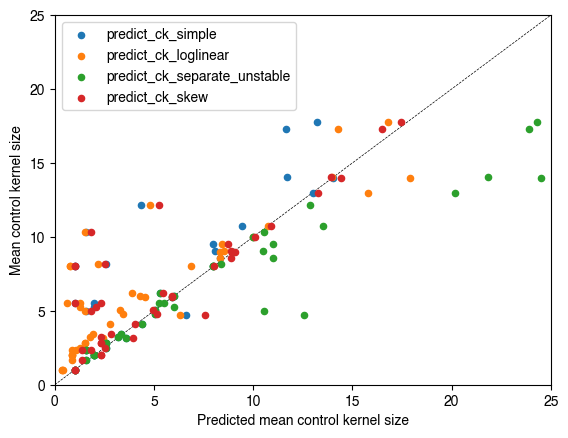

In [118]:
# plot predicted versus actual mean control kernel size

for ck_func in functions_to_test:
    plt.scatter(ck_df[ck_func.__name__],
                ck_df['mean control kernel size'],
                label=ck_func.__name__,
                s=20)

plt.xlabel('Predicted mean control kernel size')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,25
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.legend()

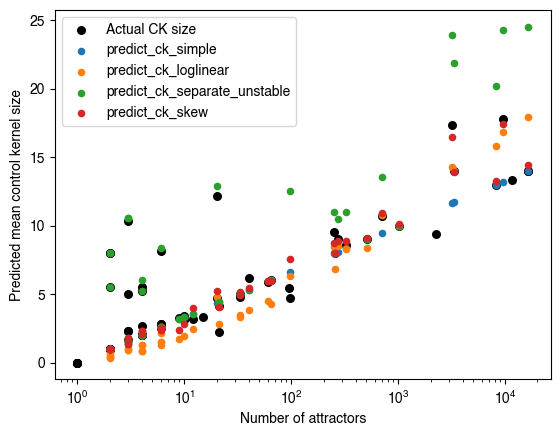

In [119]:
# plot with respect to the number of attractors

plt.scatter(ck_df['number of attractors'],
            ck_df['mean control kernel size'],
            s=30,
            label='Actual CK size',
            c='black')

for ck_func in functions_to_test:
    plt.scatter(ck_df['number of attractors'],
                ck_df[ck_func.__name__],
                label=ck_func.__name__,
                s=20)

plt.xlabel('Number of attractors')
plt.ylabel('Predicted mean control kernel size')
plt.xscale('log')
plt.legend()